In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import sklearn
from sklearn import metrics

import numpy as np
import scipy

import datetime as dt
from datetime import date

from collections import OrderedDict

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Daten aus CSV-Datei laden
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df.index.freq = "D"

#Sonnenaufgang/Sonnenuntergang laden und Tagesstunden berechnen
df["tagesstunden"] = round((pd.to_timedelta(
    pd.to_datetime(df["sonnenuntergang"]).dt.strftime("%H:%M:%S")).dt.total_seconds() - 
    pd.to_timedelta(pd.to_datetime(df["sonnenaufgang"]).dt.strftime("%H:%M:%S")).dt.total_seconds()) / 3600, 1)

df = df.drop(["sonnenaufgang", "sonnenuntergang"], axis=1)

#Windgeschwindigkeit laden
df_ = pd.read_csv("Datenbeschaffung/kalender.csv", index_col=0, parse_dates=True, usecols=[0,2])
df_ = df_.join(pd.read_csv("Datenbeschaffung/stuttgart.csv", index_col=0, parse_dates=True, usecols=[0,6], squeeze=True).rename("stuttgart"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/freiburg.csv", index_col=0, parse_dates=True, usecols=[0,6], squeeze=True).rename("freiburg"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/mannheim.csv", index_col=0, parse_dates=True, usecols=[0,6], squeeze=True).rename("mannheim"))
df_ = df_.join(pd.read_csv("Datenbeschaffung/ulm.csv", index_col=0, parse_dates=True, usecols=[0,6], squeeze=True).rename("ulm"))

#Durchschnitt berechnen
df["windgeschwindigkeit"] = round(((df_["stuttgart"] + df_["freiburg"] + df_["mannheim"] + df_["ulm"]) / 4), 1)

#Temporär für Analysen verwendete Spalten erstellen
df["windgeschwindigkeit_gerundet"] = round(df["windgeschwindigkeit"],0)

#Aufteilung in zwei DataFrames für weitere Analysen
df_arbeitstag = df[df["arbeitstag"] == 1]
df_arbeitsfreiertag = df[df["arbeitstag"] == 0]

print(df)
print()
print(df.describe().transpose())

            verbrauch     monat   wochentag  arbeitstag  temperatur  tagesstunden  windgeschwindigkeit  windgeschwindigkeit_gerundet
datum                                                                                                                               
2015-01-01     126197    Januar  Donnerstag           0        -2.5           8.4                 11.0                          11.0
2015-01-02     147085    Januar     Freitag           1        -0.0           8.4                 21.1                          21.0
2015-01-03     141426    Januar     Samstag           0         1.2           8.4                 25.6                          26.0
2015-01-04     132446    Januar     Sonntag           0        -0.2           8.4                 17.1                          17.0
2015-01-05     152611    Januar      Montag           1        -0.5           8.4                  9.4                           9.0
...               ...       ...         ...         ...         ...  

# <font size="7">Datenanalyse</font>

<font size="5">Die Windgeschwindigkeit reicht von 0 km/h bis zu etwa 35 km/h, in wenigen Fällen werden Werte von über 40 km/h erreicht. Eine Saisonalität lässt sich nicht erkennen, allerdings gibt es Anfang des Jahres gelegentlich höhere Werte.</font>

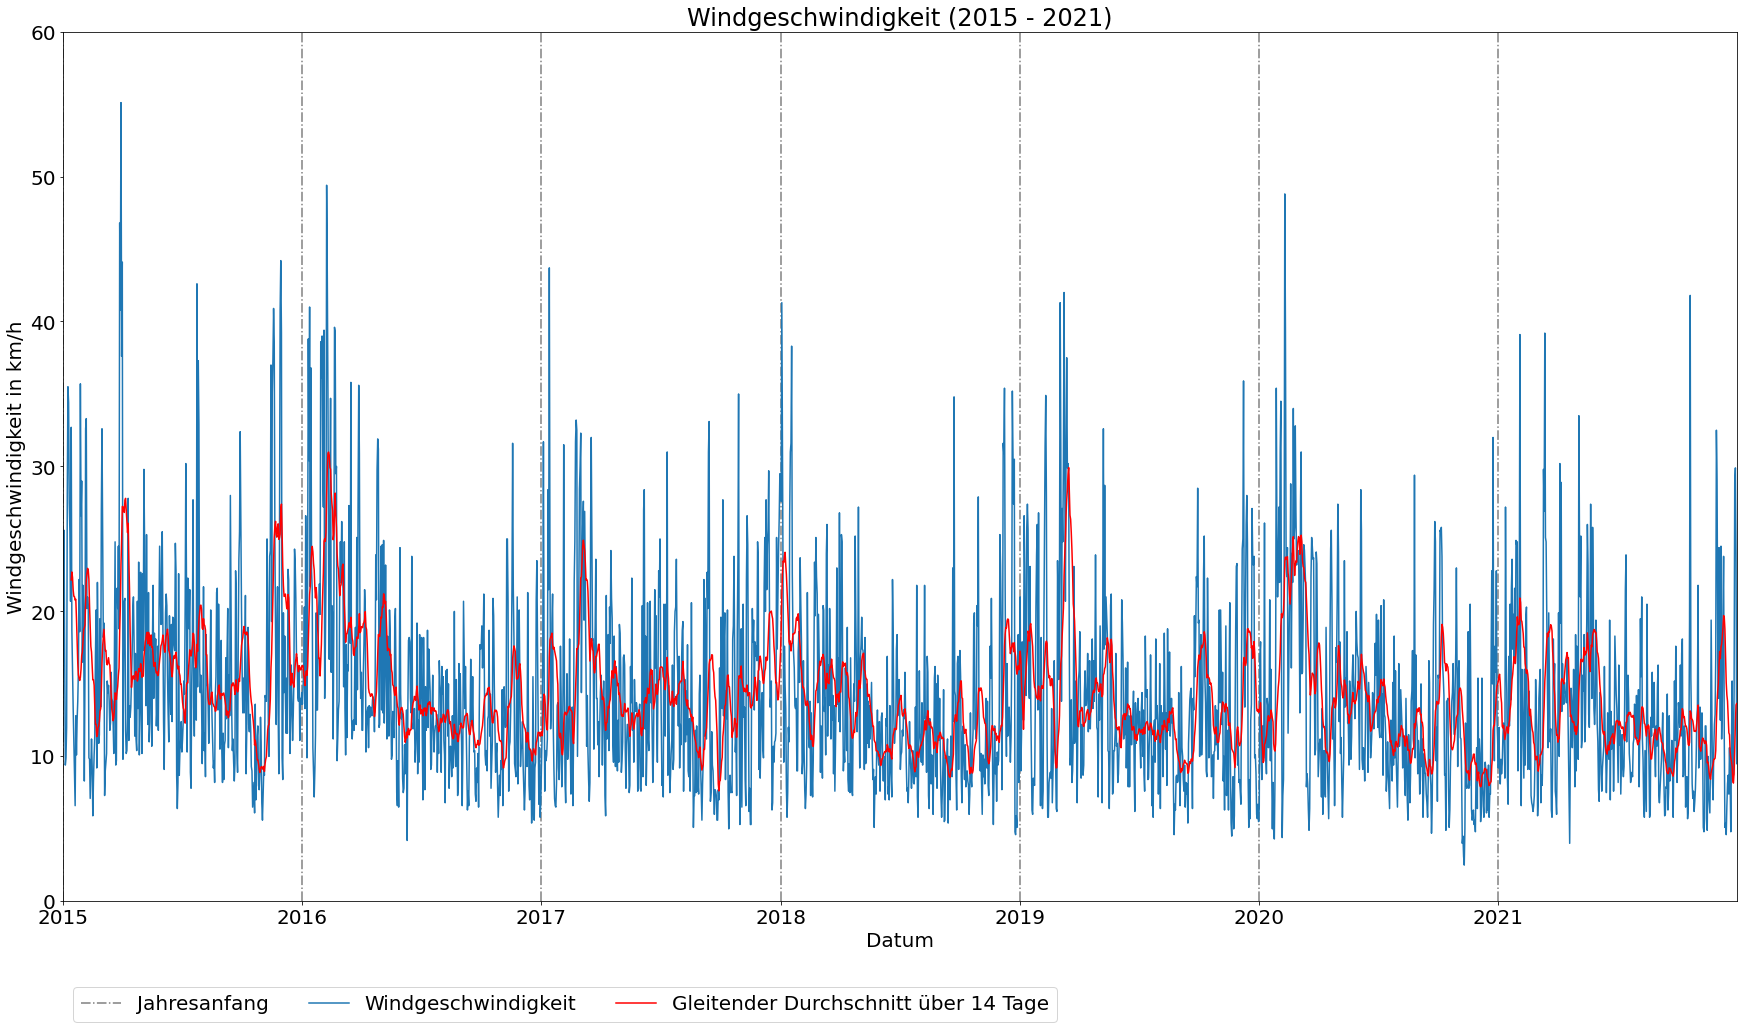

In [3]:
functions.draw_years(df)

#Niederschlag plotten
plt.plot(df["windgeschwindigkeit"], label="Windgeschwindigkeit");
plt.plot(df["windgeschwindigkeit"].rolling(window=14).mean(), color="red", label="Gleitender Durchschnitt über 14 Tage")

#Achsen und Layout
plt.title("Windgeschwindigkeit (2015 - 2021)")
plt.ylabel("Windgeschwindigkeit in km/h")
plt.ylim(0, 60)
plt.xlabel("Datum")
plt.xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

plt.show()

<font size="5">In den Boxplots lässt sich noch einmal erkennen, dass die Windgeschwindigkeit Anfang des Jahres etwas höher ist als in anderen Monaten.</font>

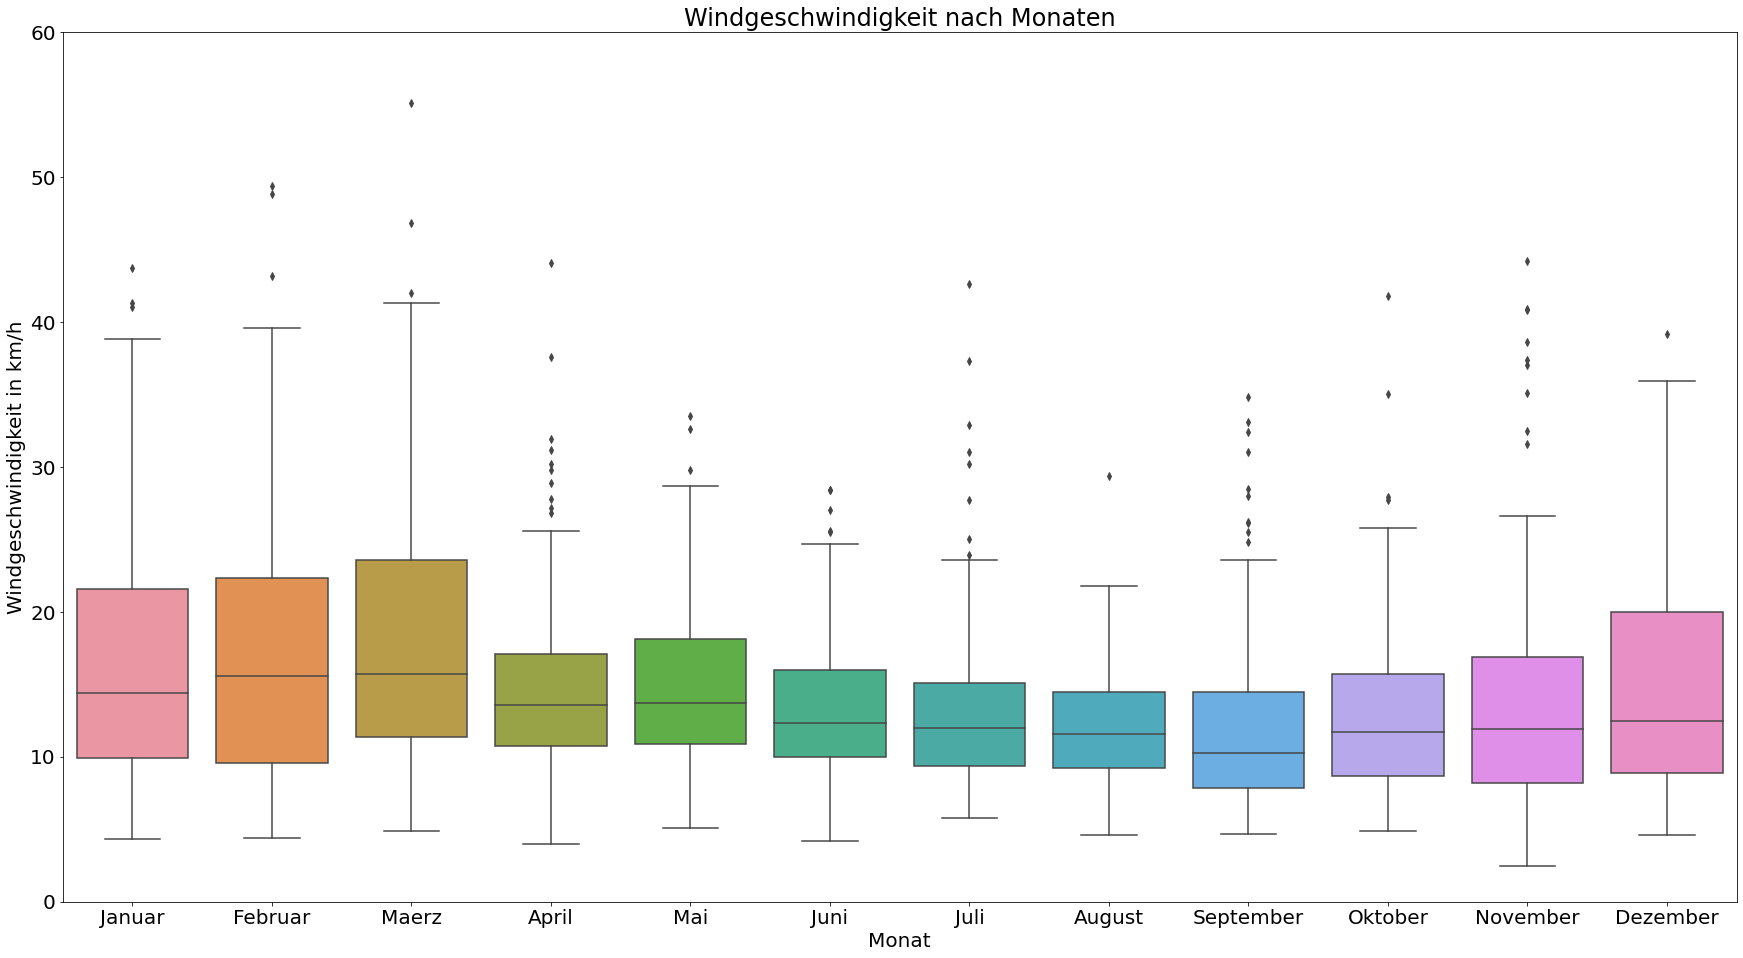

In [4]:
#Boxplot erstellen
sns.boxplot(data=df, x="monat", y="windgeschwindigkeit")

#Achsen und Layout
plt.title("Windgeschwindigkeit nach Monaten")
plt.ylabel("Windgeschwindigkeit in km/h")
plt.ylim(0, 60)
plt.xlabel("Monat")

plt.show()

<font size="5">Die Werte sind rechtsschief um den Mittelwert verteilt.</font>

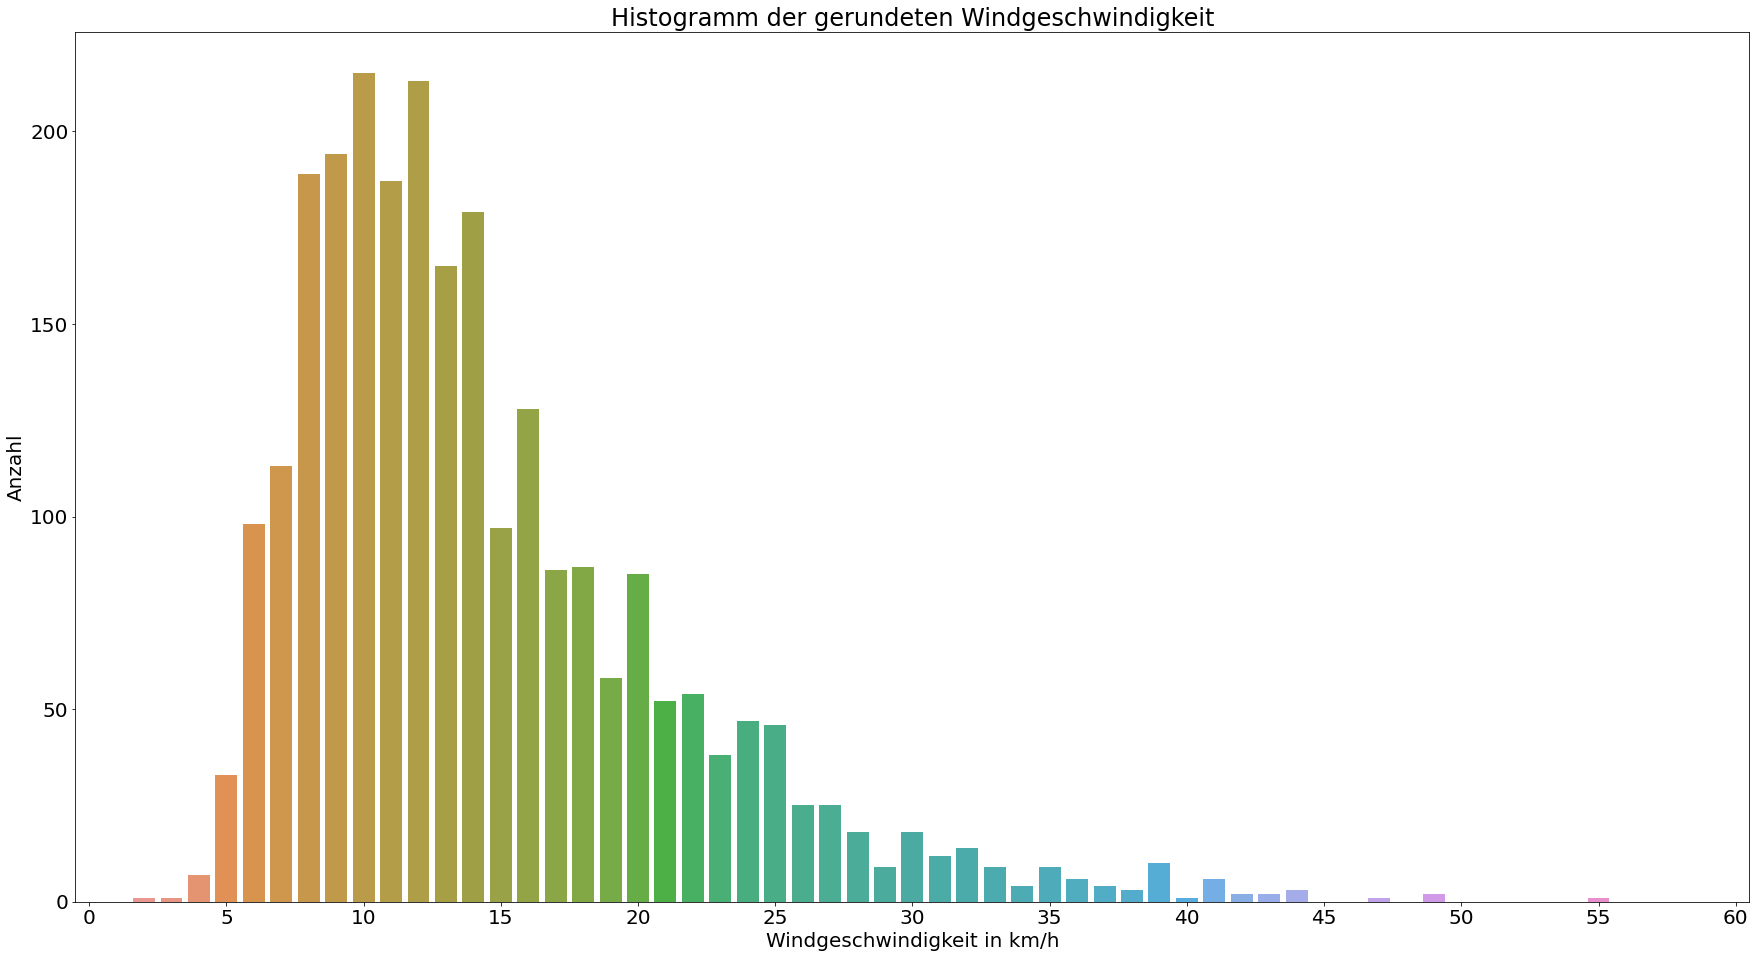

In [5]:
#Histogramm erstellen
sns.countplot(df["windgeschwindigkeit_gerundet"], order=np.arange(0, 61, 1))

#Achsen und Layout
plt.title("Histogramm der gerundeten Windgeschwindigkeit")
plt.ylabel("Anzahl")
plt.xlabel("Windgeschwindigkeit in km/h")
plt.xticks(np.arange(0, 61, 5))

plt.show()

# <font size="7">Korrelationsanalyse</font>

## <font size="6">Liniendiagramm (Verlauf)</font>

<font size="5">Es lässt sich kein Zusammenhang zwischen Stromverbrauch und Windgeschwindigkeit erkennen. Die Merkmale bewegen sich asynchron, gemeinsame oder gegensätzliche Verläufe sind nicht erkennbar. Dies gilt auch für die gleitenden Durchschnitte.</font>

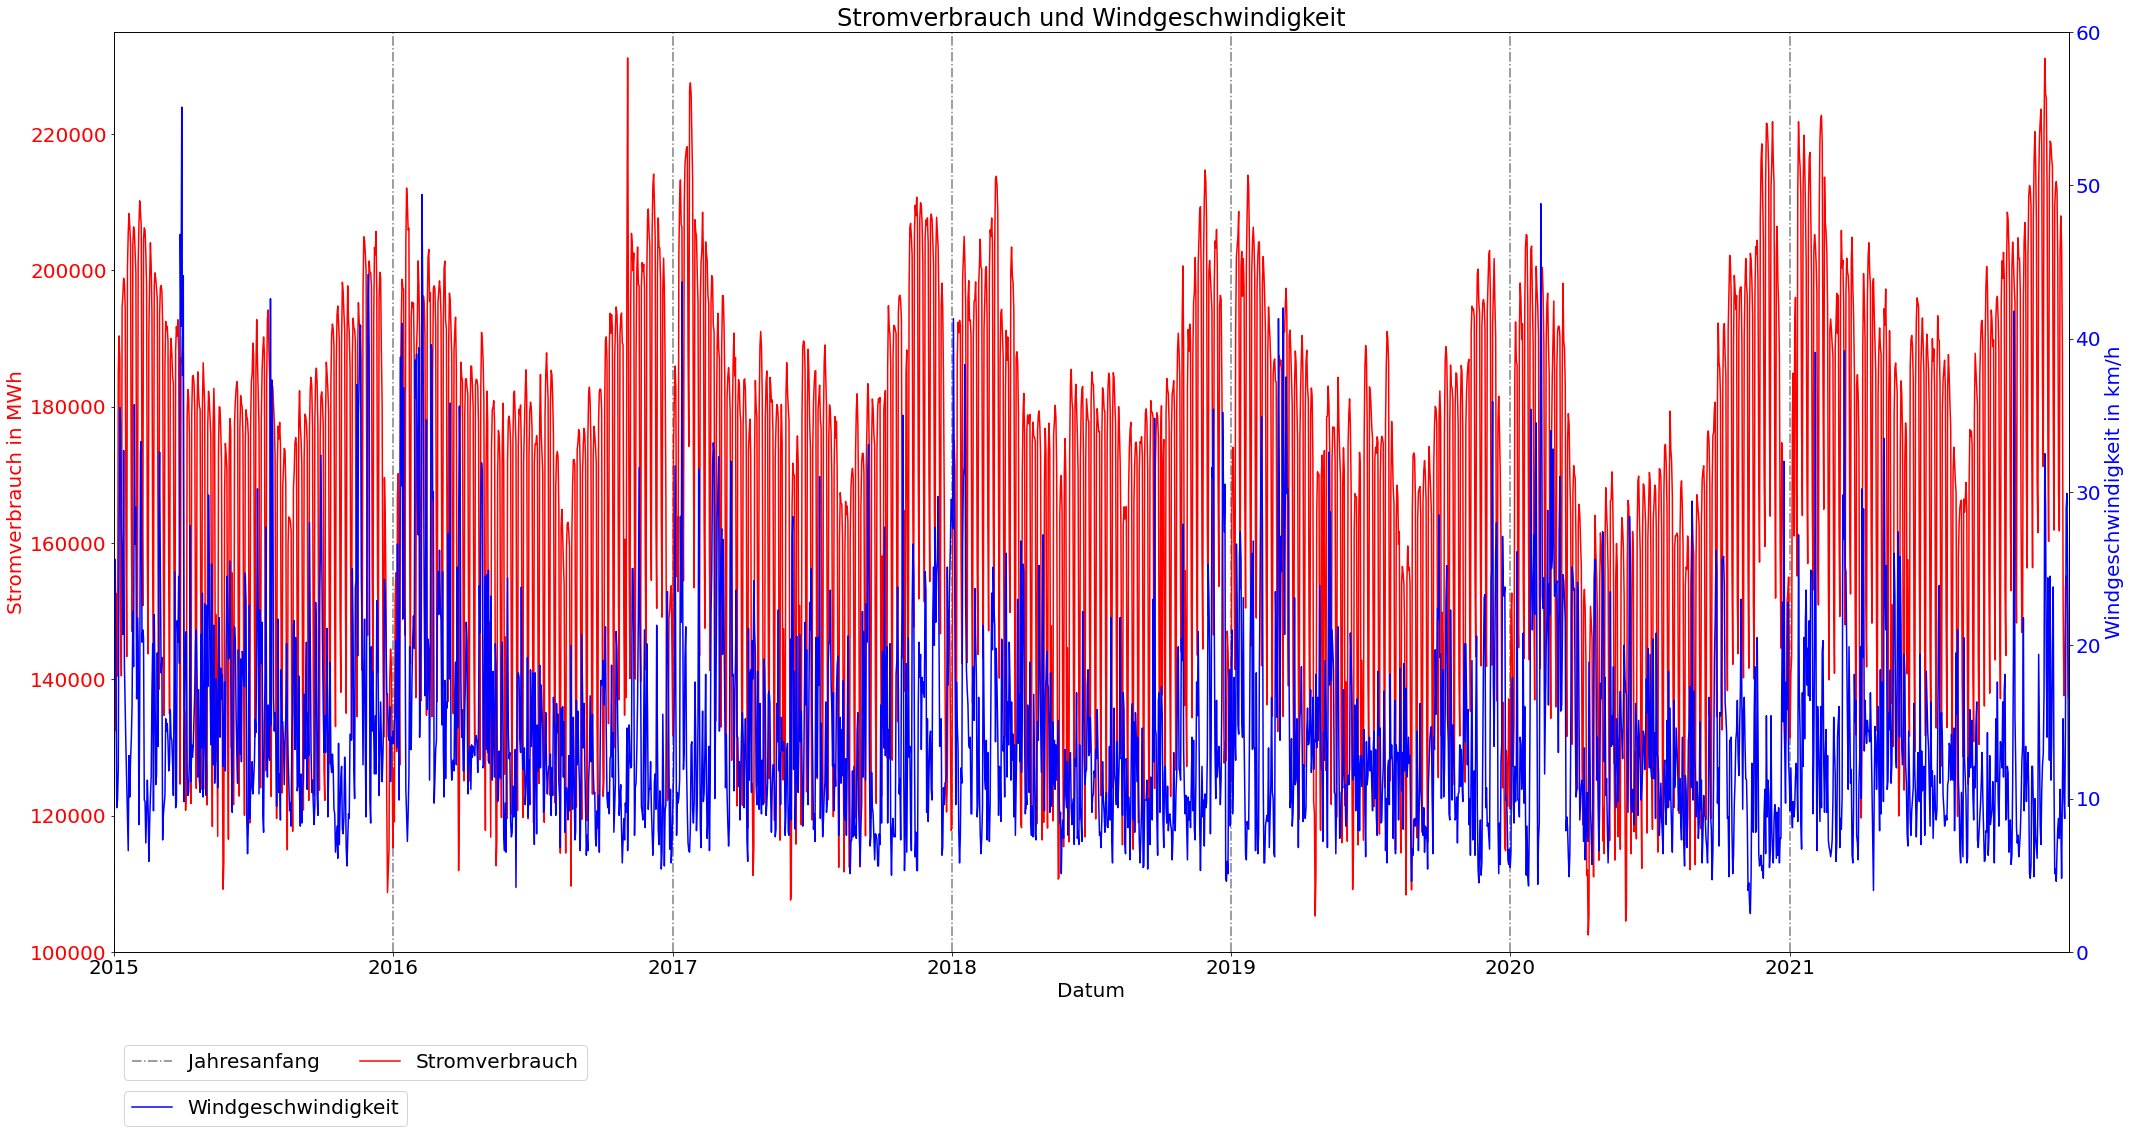

Pearson :
p-Wert von 0.096 -> Nullhypothese wird beibehalten: Daten korrelieren nicht
Spearman :
p-Wert von 0.605 -> Nullhypothese wird beibehalten: Daten korrelieren nicht
Kendall :
p-Wert von 0.58 -> Nullhypothese wird beibehalten: Daten korrelieren nicht





In [6]:
fig, ax1 = plt.subplots()

functions.draw_years(df)

ax1.set_title("Stromverbrauch und Windgeschwindigkeit")

#Verbrauch plotten
ax1.plot(df["verbrauch"], color="red", label="Stromverbrauch")
#Achsen und Layout
ax1.set_ylabel("Stromverbrauch in MWh", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_ylim(100000,235000)
ax1.set_xlabel("Datum")
ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)

ax2 = ax1.twinx()
#Windgeschwindigkeit plotten
ax2.plot(df["windgeschwindigkeit"], color="blue", label="Windgeschwindigkeit")
#Achsen und Layout
ax2.set_ylabel("Windgeschwindigkeit in km/h", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(0, 60)
ax2.set_xlabel("Datum")
ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.tight_layout()
plt.show()

#Korrelationskoeffizienten ausgeben
functions.correlation_coefficients(df["windgeschwindigkeit"], df["verbrauch"])
print("\n\n")



 Gleitender Durchschnitt über 3  Tage----------------------------------------------------------------------------------------------------------------------------------------------




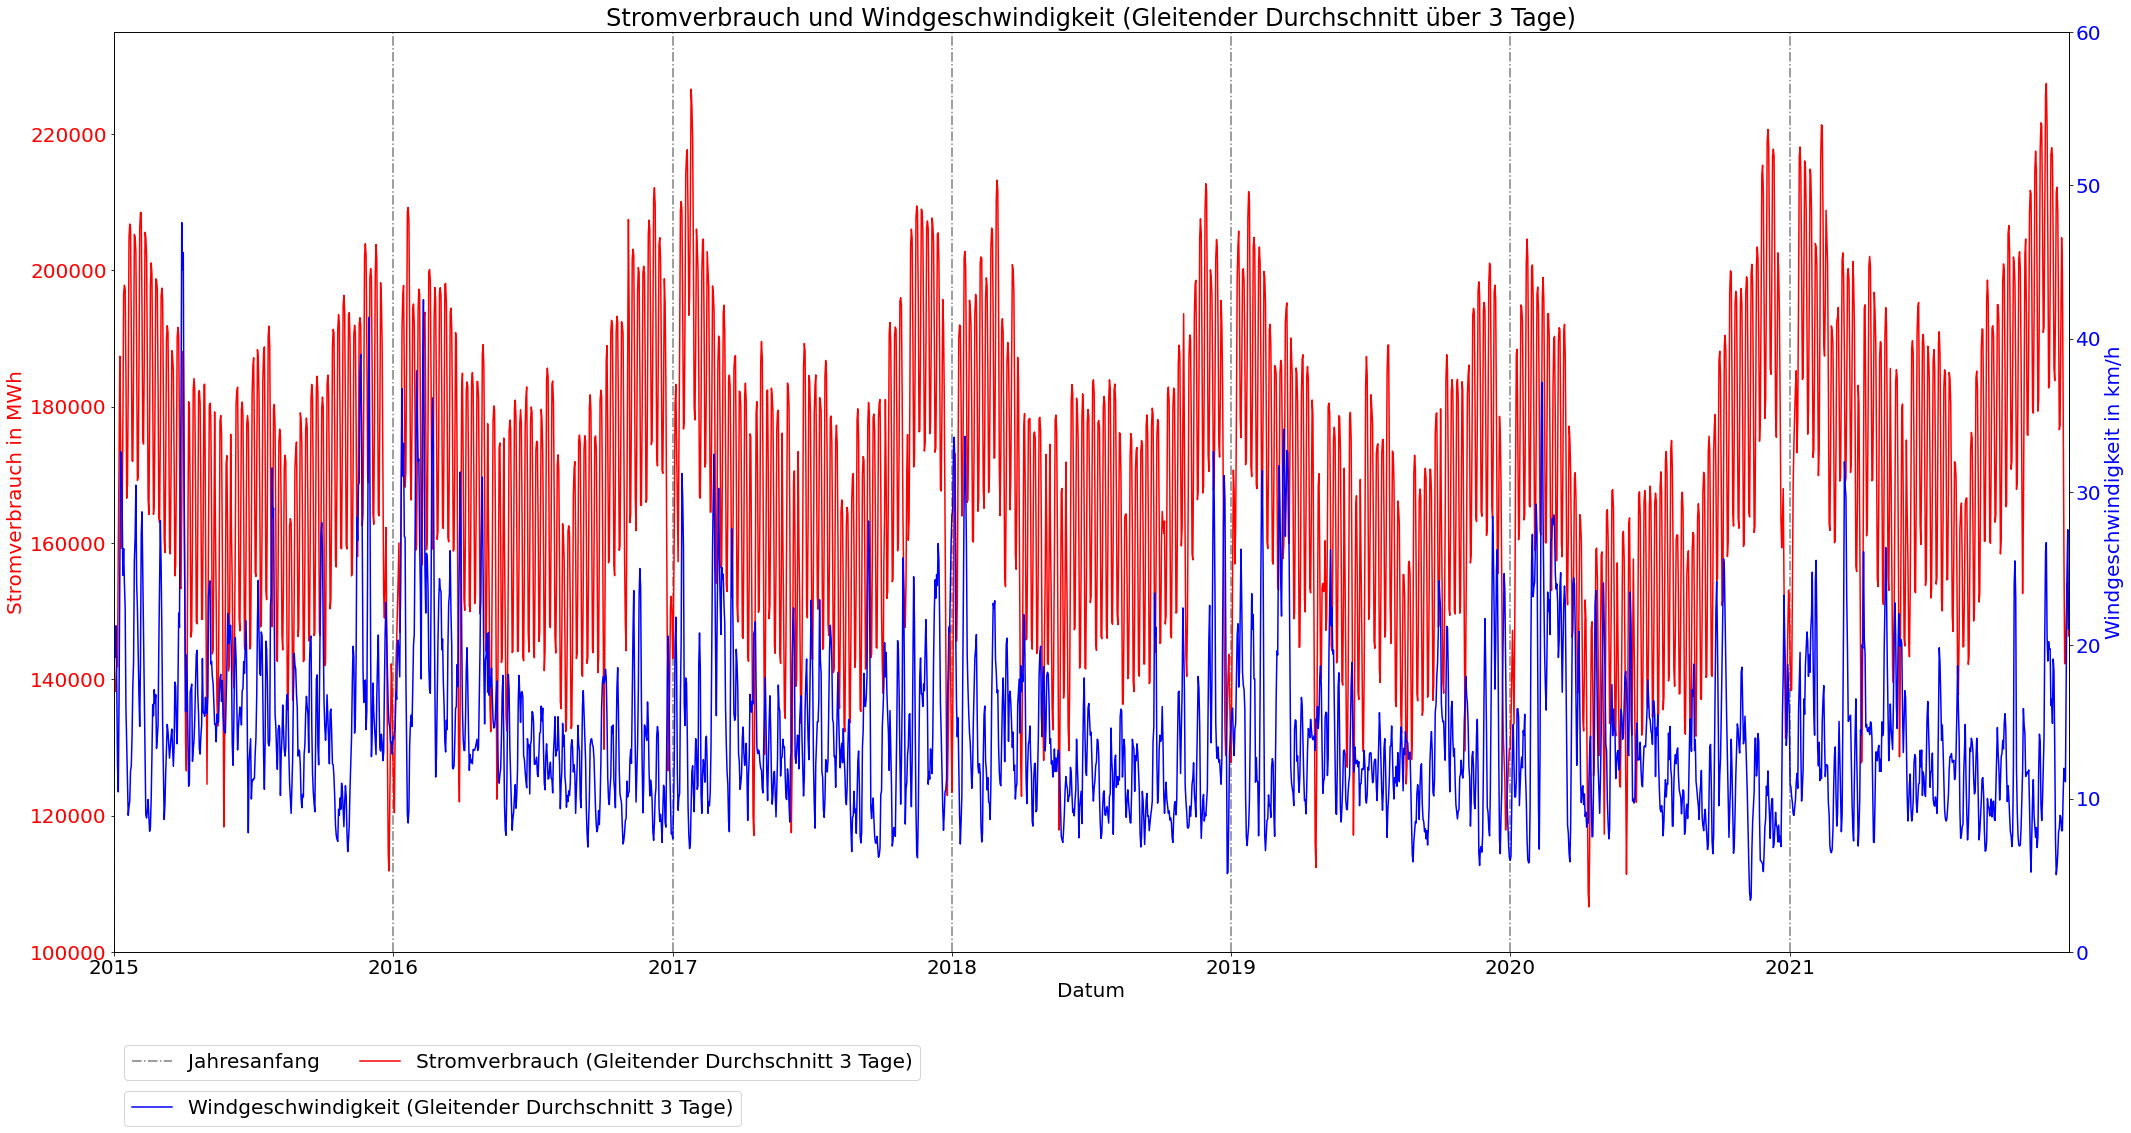

Pearson :
p-Wert von 0.024 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.045
Spearman :
p-Wert von 0.652 -> Nullhypothese wird beibehalten: Daten korrelieren nicht
Kendall :
p-Wert von 0.662 -> Nullhypothese wird beibehalten: Daten korrelieren nicht





 Gleitender Durchschnitt über 7  Tage----------------------------------------------------------------------------------------------------------------------------------------------




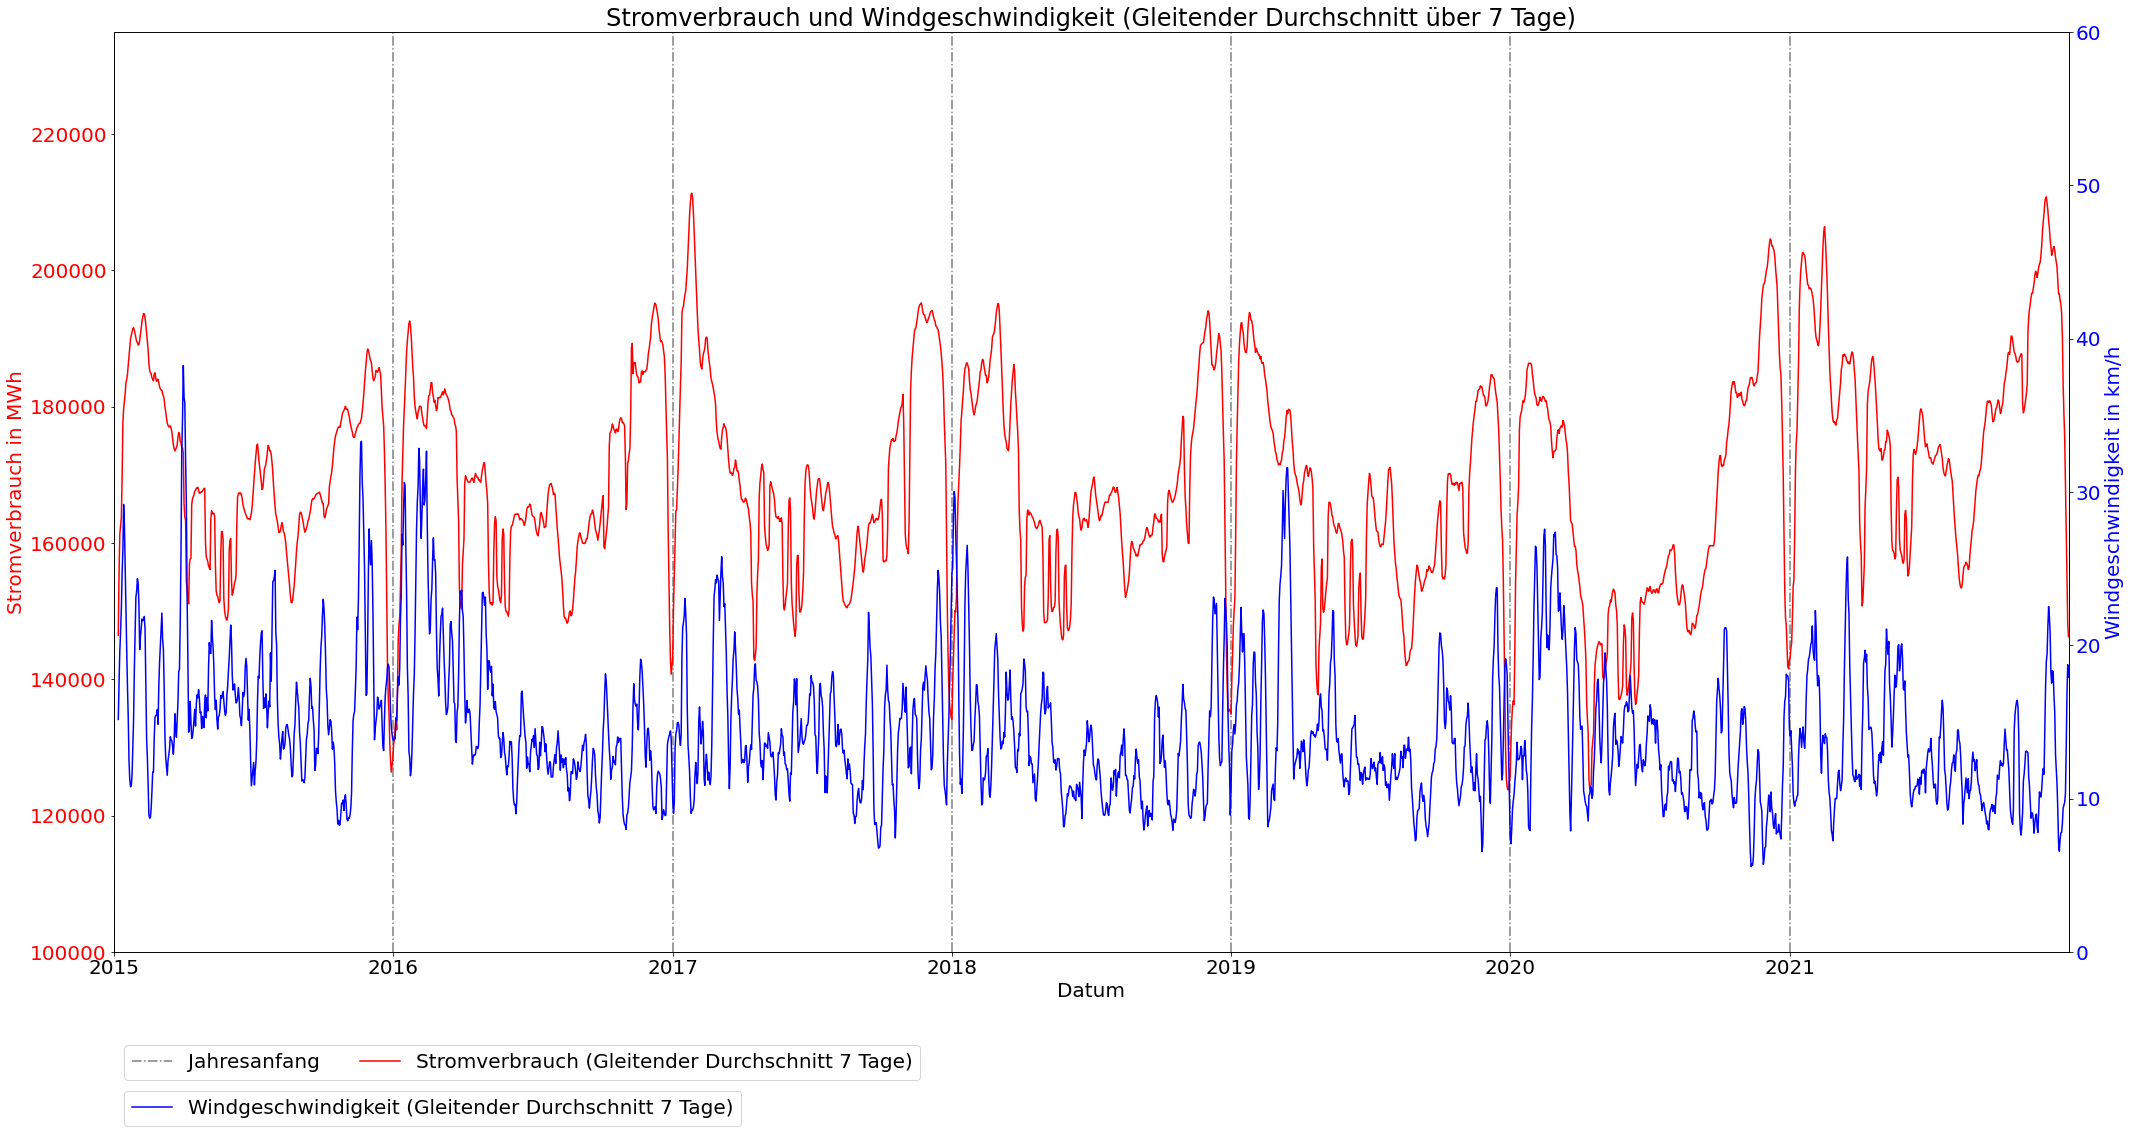

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.097
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.069
Kendall :
p-Wert von 0.001 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.045





 Gleitender Durchschnitt über 14  Tage----------------------------------------------------------------------------------------------------------------------------------------------




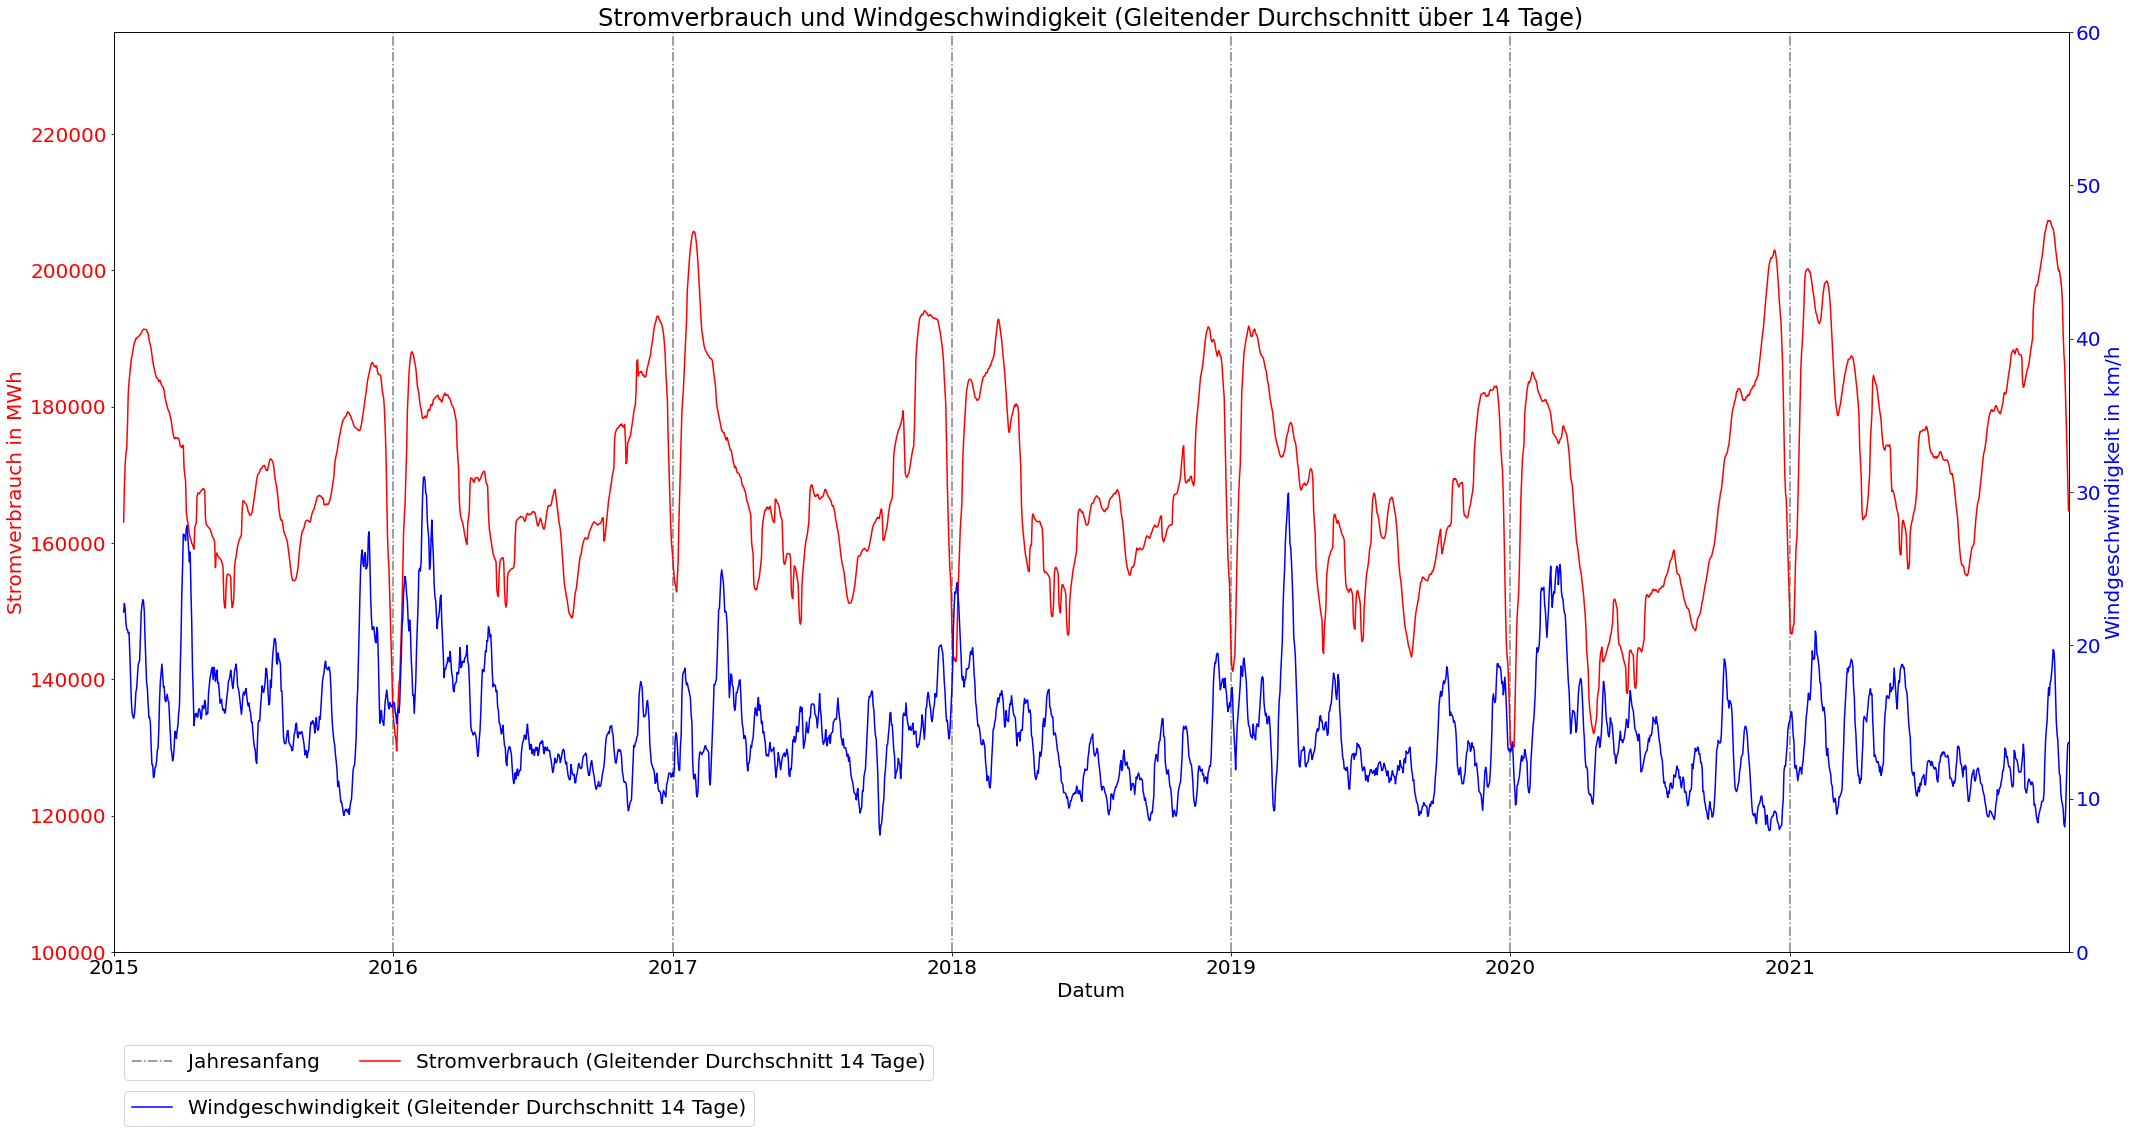

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.138
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.132
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.088





 Gleitender Durchschnitt über 28  Tage----------------------------------------------------------------------------------------------------------------------------------------------




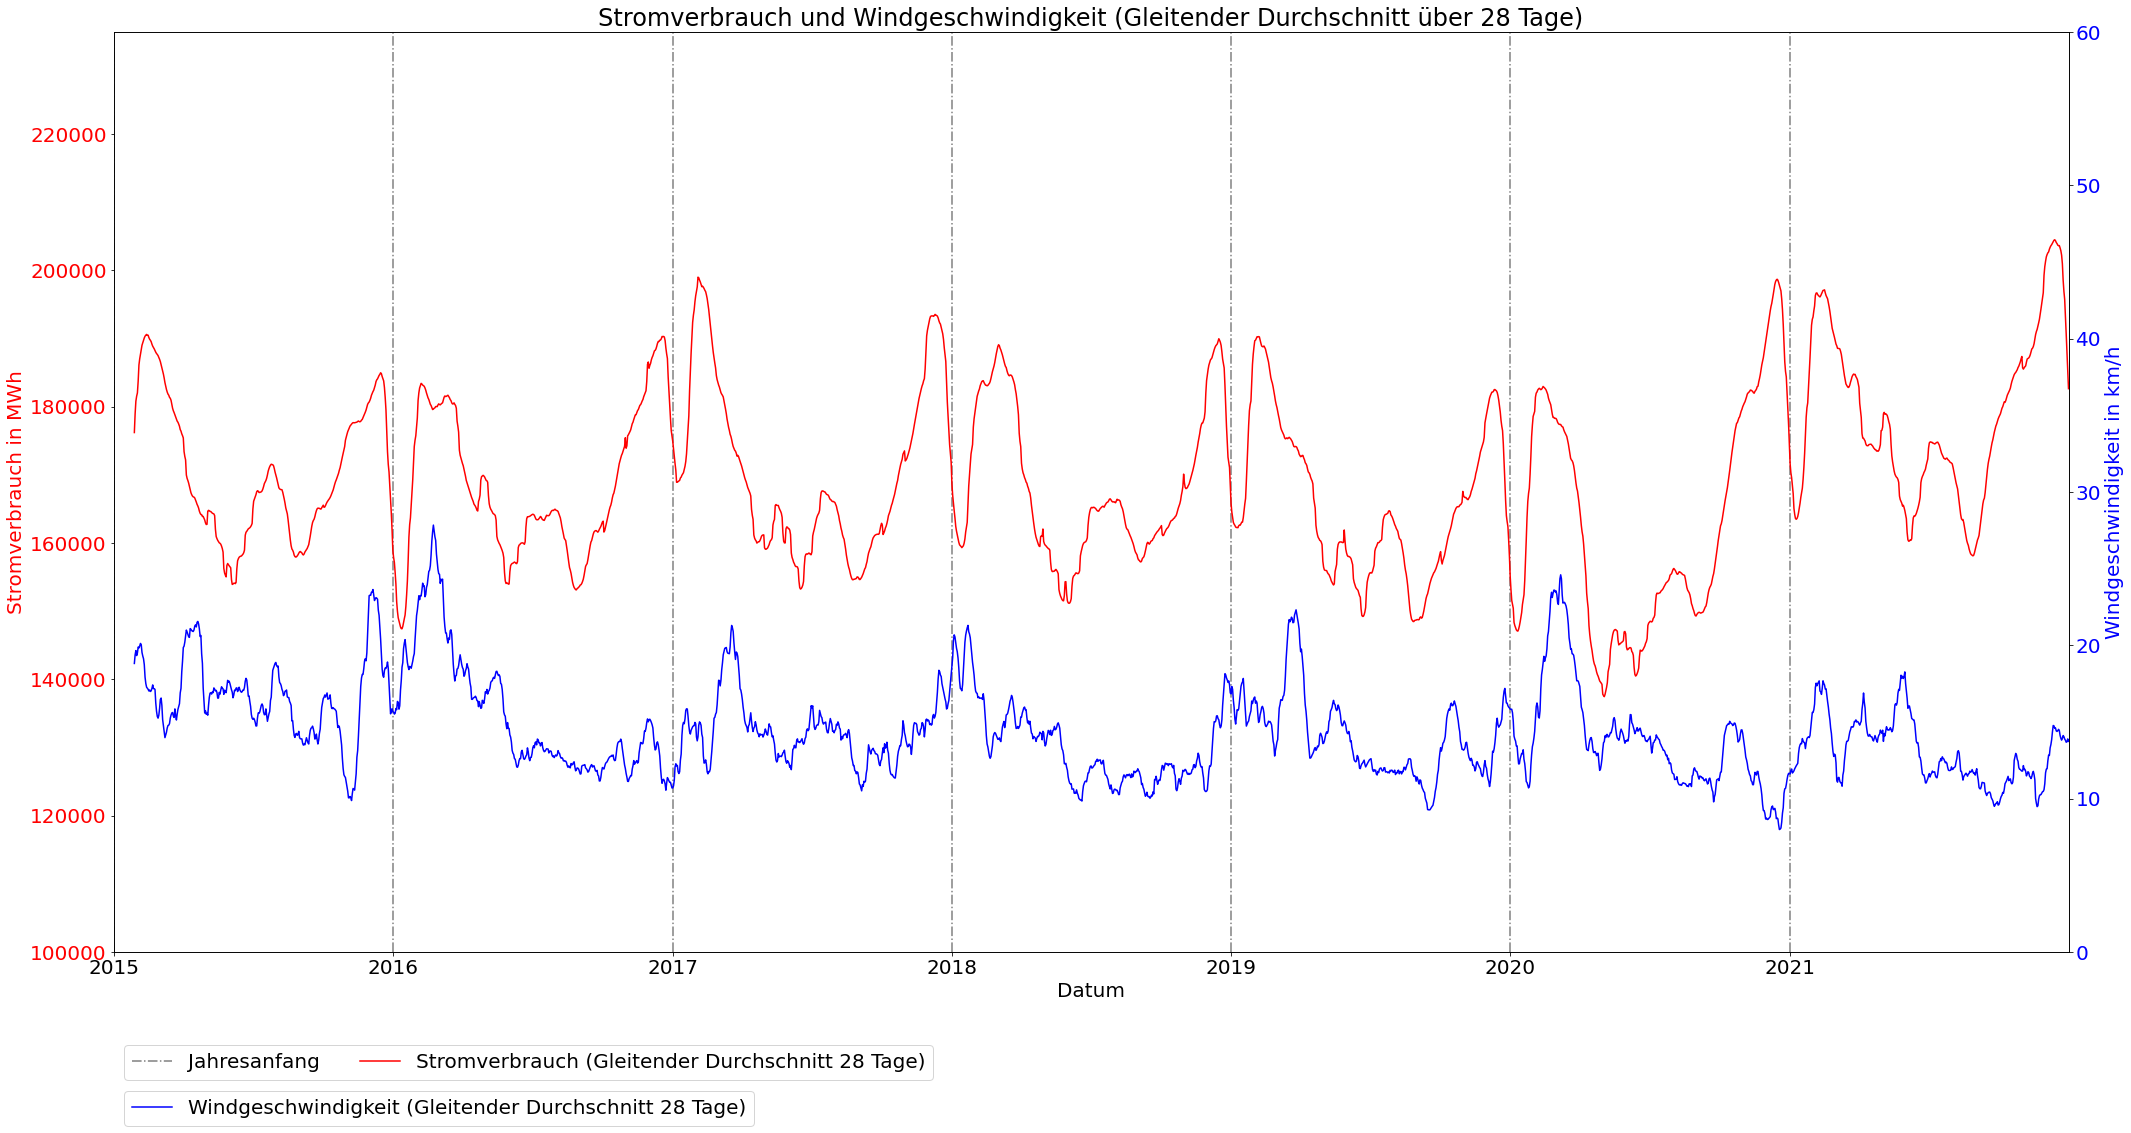

Pearson :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.182
Spearman :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.204
Kendall :
p-Wert von 0.0 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.136





In [7]:
#Durchlaufen verschiedener gleitender Durchschnitte
for window in [3, 7, 14, 28]:

    print("\n\n", "Gleitender Durchschnitt über", window," Tage----------------------------------------------------------------------------------------------------------------------------------------------\n\n")
    
    fig, ax1 = plt.subplots()

    functions.draw_years(df)

    ax1.set_title("Stromverbrauch und Windgeschwindigkeit (Gleitender Durchschnitt über " + str(window) + " Tage)")
    
    #Gleitenden Durchschnitt des Verbrauchs plotten
    ax1.plot(df["verbrauch"].rolling(window=window).mean(), color="red", label="Stromverbrauch (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax1.set_ylabel("Stromverbrauch in MWh", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.set_ylim(100000,235000)
    ax1.set_xlabel("Datum")
    ax1.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.15), ncol=4)
    
    #Gleitenden Durchschnitt der Temperatur plotten
    ax2 = ax1.twinx()
    ax2.plot(df["windgeschwindigkeit"].rolling(window=window).mean(), color="blue", label="Windgeschwindigkeit (Gleitender Durchschnitt " + str(window) + " Tage)")
    #Achsen und Layout
    ax2.set_ylabel("Windgeschwindigkeit in km/h", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_ylim(0, 60)
    ax2.set_xlabel("Datum")
    ax2.set_xlim(dt.datetime(2015,1,1), dt.datetime(2021,12,31))

    #Legende einfügen
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

    plt.tight_layout()
    plt.show()

    #Korrelationskoeffizienten ausgeben
    functions.correlation_coefficients(df["windgeschwindigkeit"].rolling(window=window).mean().dropna(), df["verbrauch"].rolling(window=window).mean().dropna())
    print("\n\n")

## <font size="6">Stromverbrauch nach Windgeschwindigkeit (Scatterplot)</font>

<font size="5">Auch im Scatterplot lässt sich zunächst kein Zusammenhang feststellen. Die lineare Regression deutet zwar darauf hin, dass der Stromverbrauch mit der Windgeschwindigkeit leicht zu steigen scheint, allerdings handelt es sich hier eher um einen zufälligen Effekt, der unter anderem durch Ausreißer und die bereits oben beschriebene Verteilung zurückzuführen ist.</font>

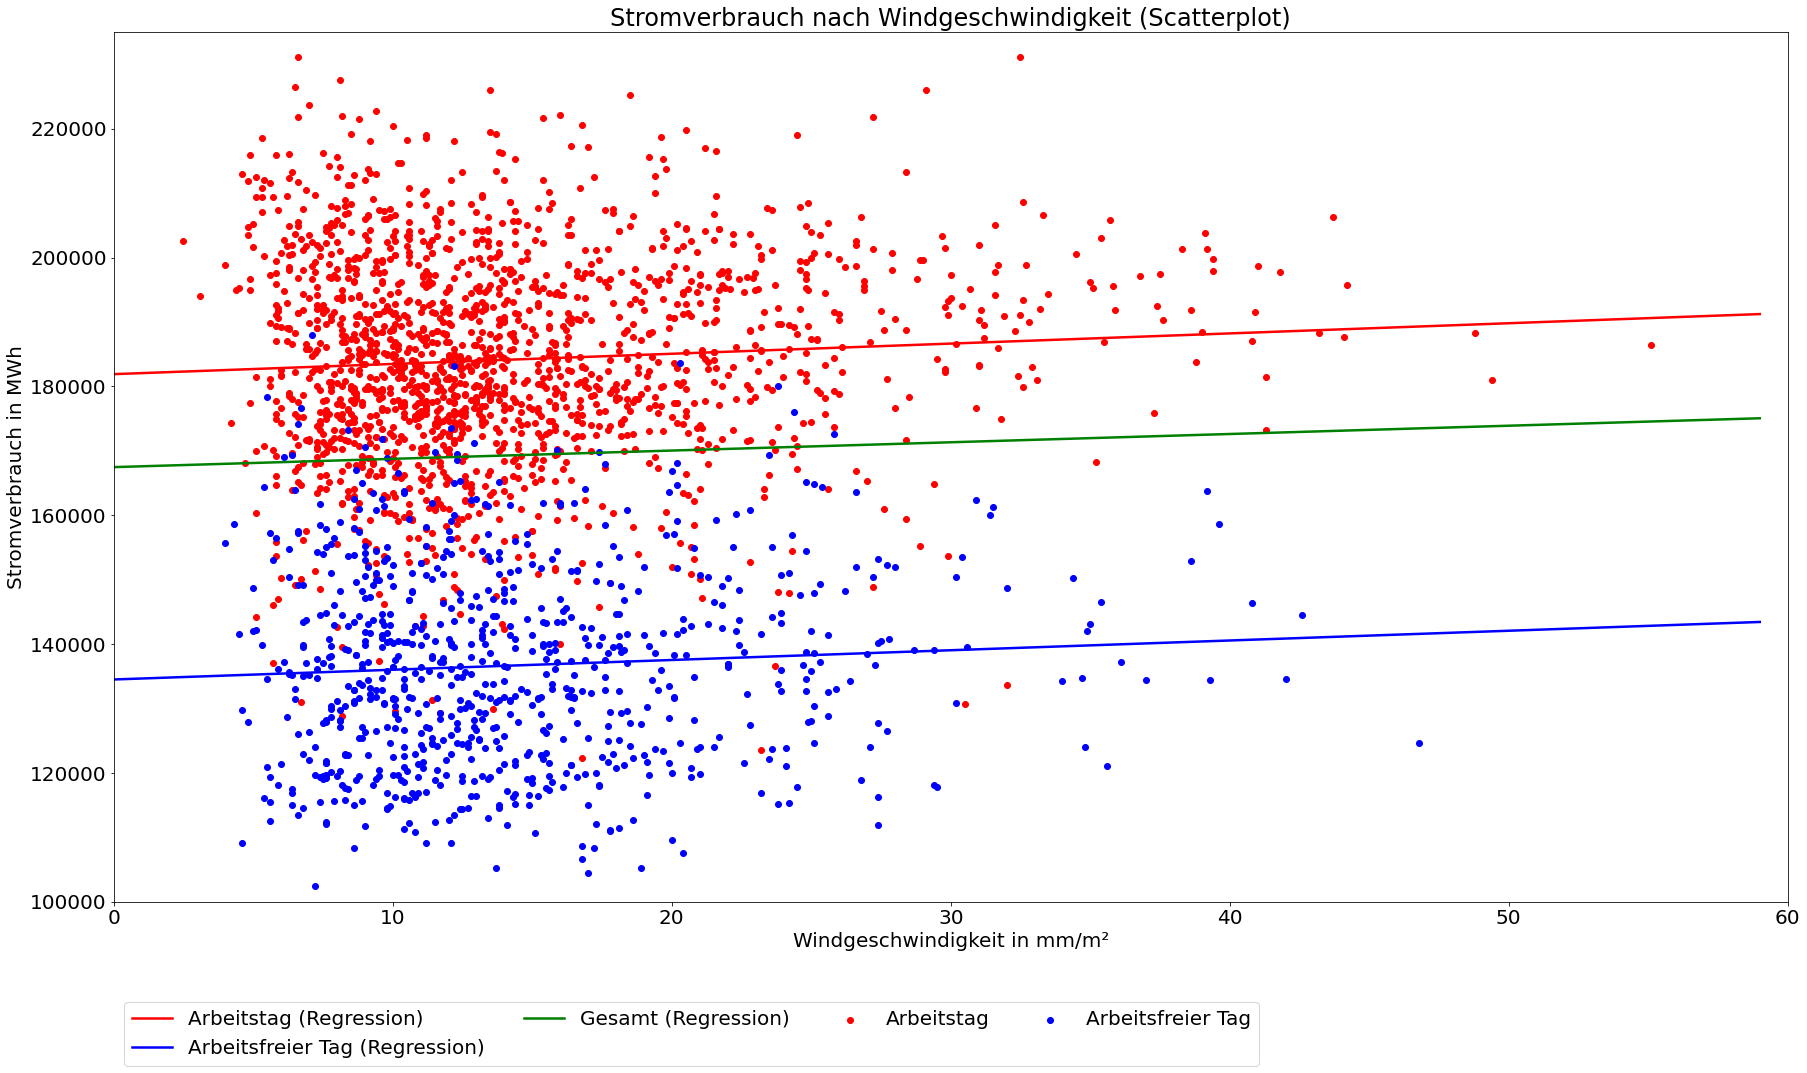

Arbeitstage
Pearson :
p-Wert von 0.004 -> Nullhypothese wird abgelehnt: Die Daten korrelieren mit einem Koeffizienten von 0.069
Spearman :
p-Wert von 0.085 -> Nullhypothese wird beibehalten: Daten korrelieren nicht
Kendall :
p-Wert von 0.066 -> Nullhypothese wird beibehalten: Daten korrelieren nicht


Arbeitsfreie Tage
Pearson :
p-Wert von 0.06 -> Nullhypothese wird beibehalten: Daten korrelieren nicht
Spearman :
p-Wert von 0.176 -> Nullhypothese wird beibehalten: Daten korrelieren nicht
Kendall :
p-Wert von 0.163 -> Nullhypothese wird beibehalten: Daten korrelieren nicht


In [8]:
x = range(0, 60, 1)

#Windgeschwindigkeit und Verbrauch an Arbeitstagen plotten
plt.scatter(df_arbeitstag["windgeschwindigkeit"], df_arbeitstag["verbrauch"], color="red", label="Arbeitstag")
#Steigung und Intercept für Regression bilden
m1, b1 = np.polyfit(df_arbeitstag["windgeschwindigkeit"], df_arbeitstag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m1 * x + b1, color="red", linewidth=2.5, label="Arbeitstag (Regression)")

#Windgeschwindigkeit und Verbrauch an arbeitsfreien Tagen plotten
plt.scatter(df_arbeitsfreiertag["windgeschwindigkeit"], df_arbeitsfreiertag["verbrauch"], color="blue", label="Arbeitsfreier Tag")
#Steigung und Intercept für Regression bilden
m2, b2 = np.polyfit(df_arbeitsfreiertag["windgeschwindigkeit"], df_arbeitsfreiertag["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m2 * x + b2, color="blue", linewidth=2.5, label="Arbeitsfreier Tag (Regression)")

#Steigung und Intercept für Regression mit allen Tagen bilden
m3, b3 = np.polyfit(df["windgeschwindigkeit"], df["verbrauch"], 1)
#Regressionsfunktion einzeichnen
plt.plot(x, m3 * x + b3, color="green", linewidth=2.5, label="Gesamt (Regression)")

#Achsen und Layout
plt.title("Stromverbrauch nach Windgeschwindigkeit (Scatterplot)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000, 235000)
plt.xlabel("Windgeschwindigkeit in mm/m²")
plt.xlim(0, 60)

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=4)

plt.show()

#Korrelationskoeffizienten ausgeben
print("Arbeitstage")
functions.correlation_coefficients(df_arbeitstag["windgeschwindigkeit"], df_arbeitstag["verbrauch"])
print("\n\nArbeitsfreie Tage")
functions.correlation_coefficients(df_arbeitsfreiertag["windgeschwindigkeit"], df_arbeitsfreiertag["verbrauch"])

## <font size="6">Stromverbrauch nach Windgeschwindigkeit (Boxplot)</font><a class="anchor" id="2-07b-boxplots"></a>

<font size="5">Auch in den Boxplots lässt sich kein Zusammenhang zwischen der Windgeschwindigkeit und dem Stromverbrauch erkennen.</font>

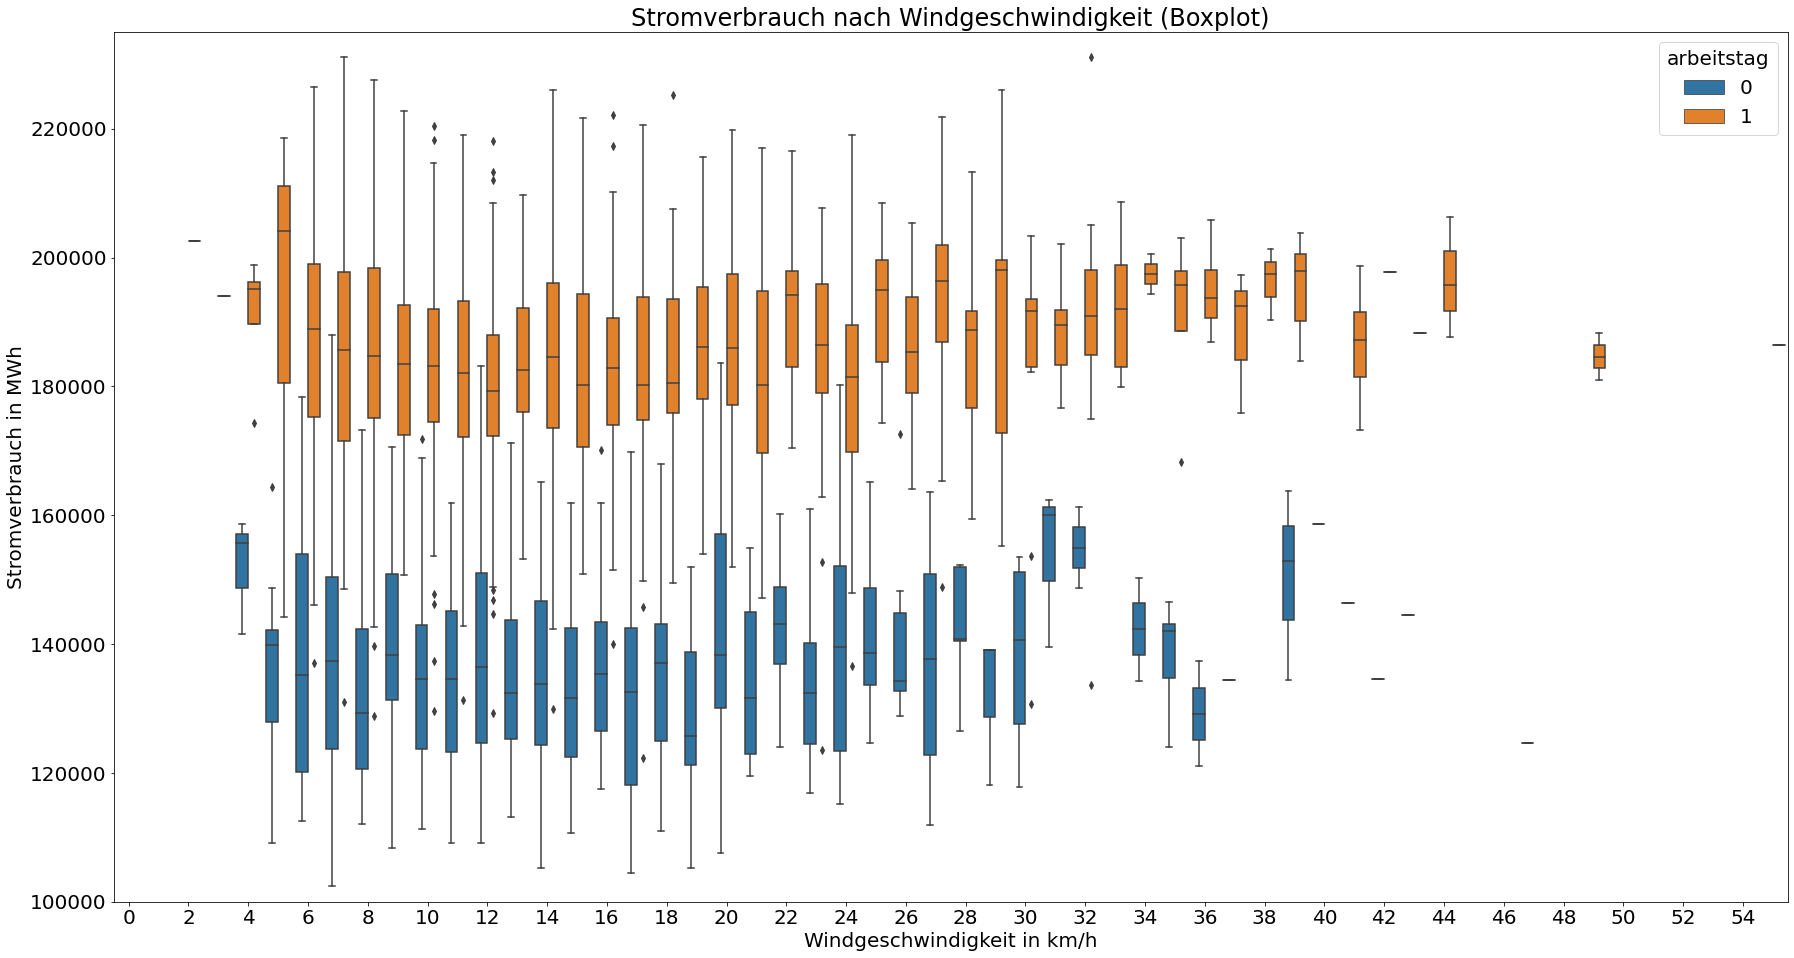

In [9]:
#Boxplot der gerundeten Windgeschwindigkeit
sns.boxplot(data=df, x="windgeschwindigkeit_gerundet", y="verbrauch", hue="arbeitstag", order=np.arange(0, 56, 1))

#Achsen und Layout
plt.title("Stromverbrauch nach Windgeschwindigkeit (Boxplot)")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.xlabel("Windgeschwindigkeit in km/h")
plt.xticks(range(0,56,2))

plt.show()

# <font size="7">Regressionsanalyse</font>

<font size="5">Durch die Regressionsanalyse wird geprüft, inwieweit sich der Verlauf des Stromverbrauchs anhand der verfügbaren exogenen Merkmale modellieren lässt. Es geht dabei noch nicht um die Erstellung eines Vorhersagemodells. Stattdessen wird die Regressionsanalyse eher mit Blick auf potenzielle Zusammenhänge, Korrelationen und Muster beziehungsweise generelle Verläufe durchgeführt. Aus diesem Grund bietet sich eine Funktion sechsten Grades an. Dafür wird mit den Daten von 2015 bis 2018 und den entsprechenden Merkmalen eine Regression sechsten Grades durchgeführt, welche dann mit den Daten für 2019 getestet wird. Wie bereits erwähnt, gibt es 2020 und 2021 Abweichungen vom ansonsten üblichen Verlauf. Daher werden nur die Daten bis einschließlich 2019 verwendet.</font>

## <font size="6">Regression mit Windgeschwindigkeit</font>

<font size="5">Die Regression auf die Windgeschwindigkeit zeigt, dass das Modell so gut wie gar keine Informationen aus den Daten generalisieren kann. Es kann weder die wöchentliche noch die jährliche Saisonalität erfasst werden. Mit fast 15% Abweichung ist das Modell praktisch unbrauchbar.</font>

            verbrauch  windgeschwindigkeit
datum                                     
2015-01-01   126197.0                 11.0
2015-01-02   147085.0                 21.1
2015-01-03   141426.0                 25.6
2015-01-04   132446.0                 17.1
2015-01-05   152611.0                  9.4
...               ...                  ...
2019-12-27   129551.0                 10.1
2019-12-28   125395.0                  8.9
2019-12-29   121331.0                  6.0
2019-12-30   137130.0                  5.7
2019-12-31   131060.0                  6.7

[1826 rows x 2 columns]
       Vorhersage
R2           -0.0
MAE       21754.5
MSE   710997300.2
RMSE      26664.5
                 
MAPE       14.7 %


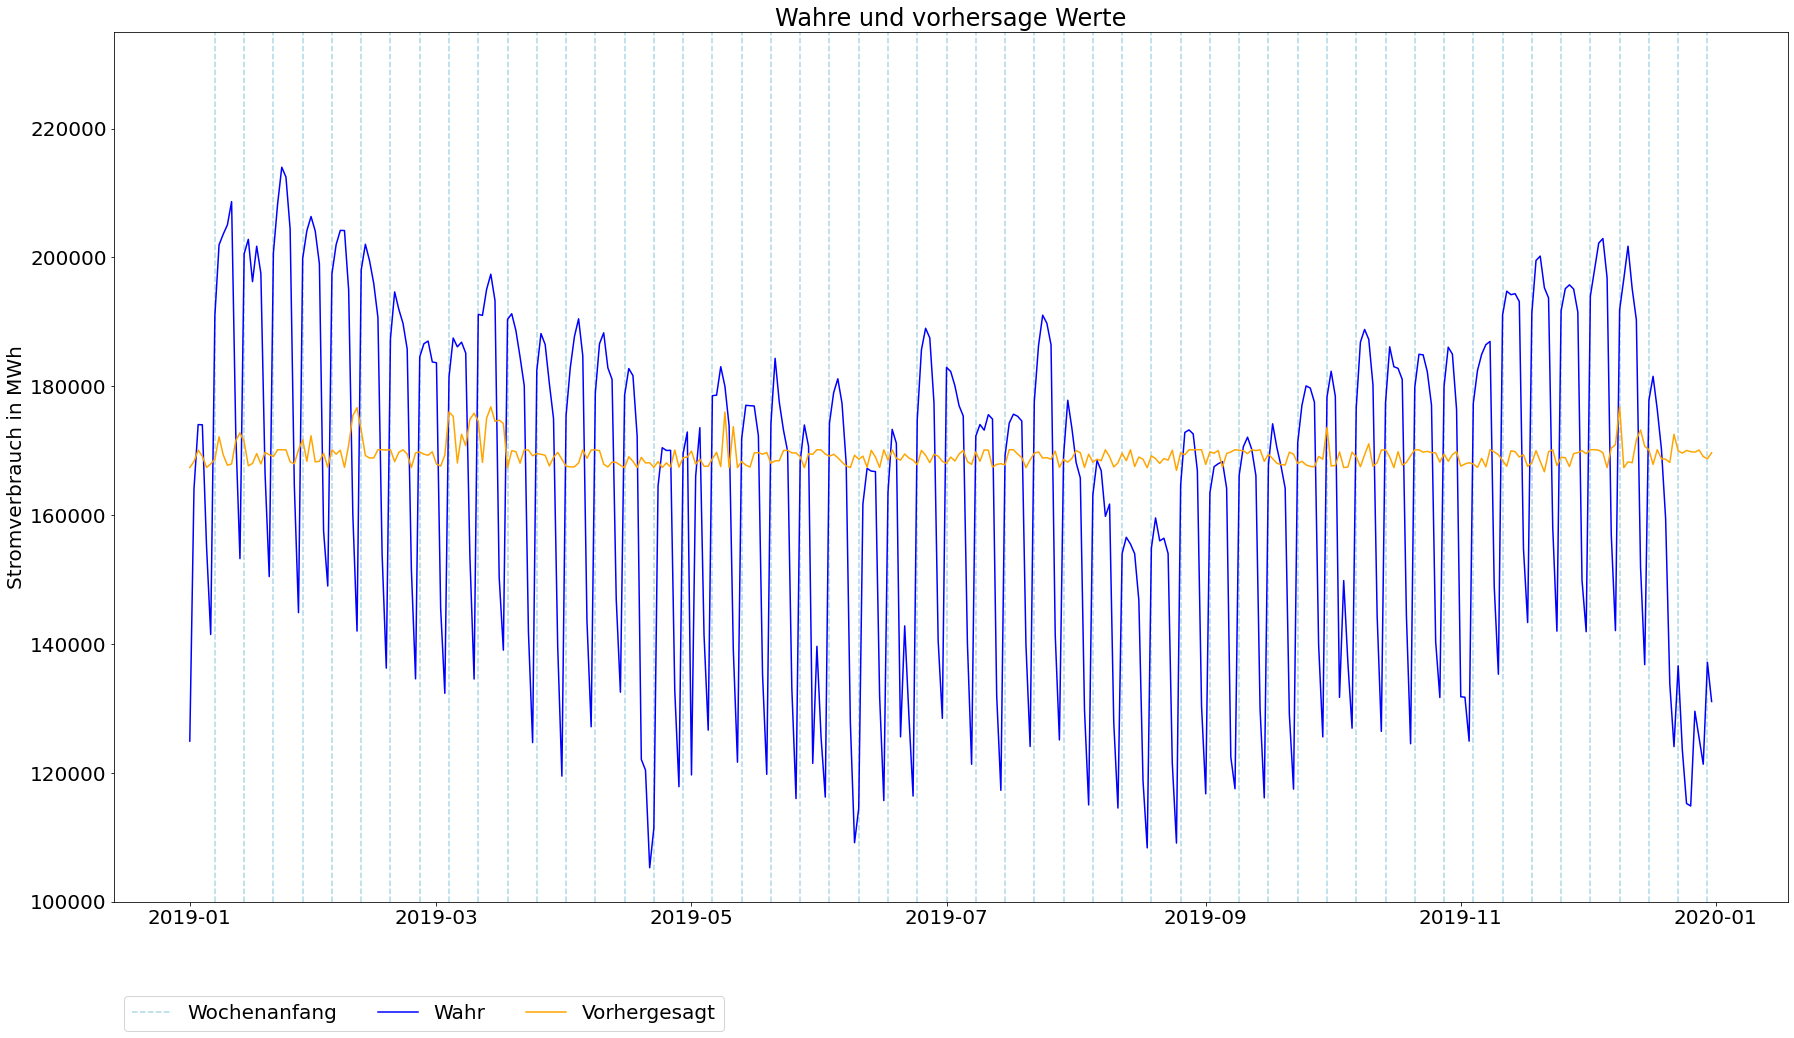

In [10]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["windgeschwindigkeit"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["windgeschwindigkeit"]].values.reshape(-1, 1))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["windgeschwindigkeit"]])
X_test = pf.transform(test[["windgeschwindigkeit"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstag und Windgeschwindigkeit</font>

<font size="5">Wird das Modell um die Arbeitstage erweitert, kann zwar die wöchentliche Saisonalität abgebildet werden, allerdings sind quasi alle Verbesserungen auf den Indikator für Arbeitstage zurückzuführen. Ein zusätzlicher Informationsgehalt lässt sich bei der Windgeschwindigkeit nicht erkennen.</font>

            verbrauch  arbeitstag  windgeschwindigkeit
datum                                                 
2015-01-01   126197.0         0.0                 11.0
2015-01-02   147085.0         1.0                 21.1
2015-01-03   141426.0         0.0                 25.6
2015-01-04   132446.0         0.0                 17.1
2015-01-05   152611.0         1.0                  9.4
...               ...         ...                  ...
2019-12-27   129551.0         1.0                 10.1
2019-12-28   125395.0         0.0                  8.9
2019-12-29   121331.0         0.0                  6.0
2019-12-30   137130.0         1.0                  5.7
2019-12-31   131060.0         1.0                  6.7

[1826 rows x 3 columns]
       Vorhersage
R2            0.7
MAE       11706.7
MSE   224114606.8
RMSE      14970.5
                 
MAPE        7.6 %


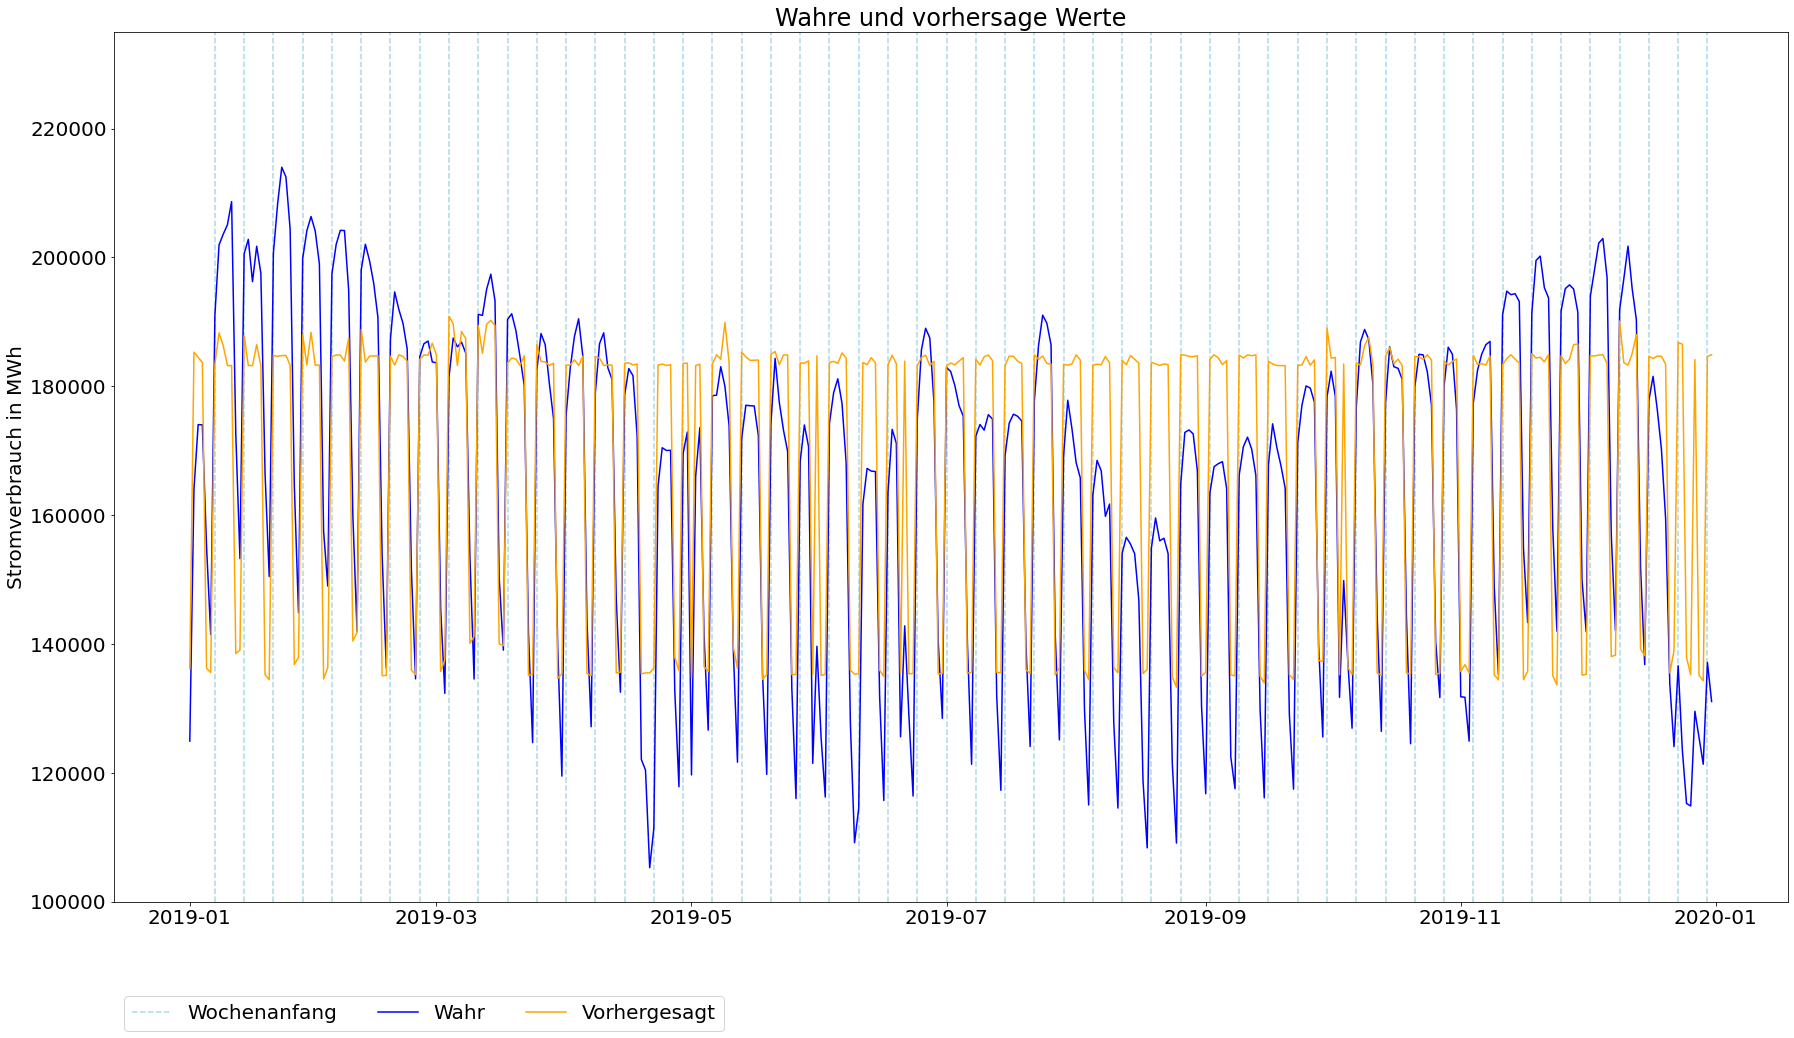

In [11]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["arbeitstag"], df["windgeschwindigkeit"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=6)
pf = pf.fit(df_regression[["arbeitstag", "windgeschwindigkeit"]].values.reshape(-2, 2))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["arbeitstag", "windgeschwindigkeit"]])
X_test = pf.transform(test[["arbeitstag", "windgeschwindigkeit"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

## <font size="6">Regression mit Arbeitstagen, Temperatur, Tagesstunden und Windgeschwindigkeit</font>

<font size="5">Wird die Windgeschwindigkeit den aussagekräftigen Merkmalen hinzugefügt, lässt sich auch hier keine zusätzliche Verbesserung erzielen. Die aussagekräftigen Merkmale werden stattdessen durch das zusätzlich Merkmal verwässert und die Qualität des Modells verschlechtert sich.</font>

            verbrauch  tagesstunden  arbeitstag  temperatur  windgeschwindigkeit
datum                                                                           
2015-01-01   126197.0           8.4         0.0        -2.5                 11.0
2015-01-02   147085.0           8.4         1.0        -0.0                 21.1
2015-01-03   141426.0           8.4         0.0         1.2                 25.6
2015-01-04   132446.0           8.4         0.0        -0.2                 17.1
2015-01-05   152611.0           8.4         1.0        -0.5                  9.4
...               ...           ...         ...         ...                  ...
2019-12-27   129551.0           8.3         1.0         5.1                 10.1
2019-12-28   125395.0           8.3         0.0         1.7                  8.9
2019-12-29   121331.0           8.3         0.0         1.1                  6.0
2019-12-30   137130.0           8.3         1.0         2.8                  5.7
2019-12-31   131060.0       

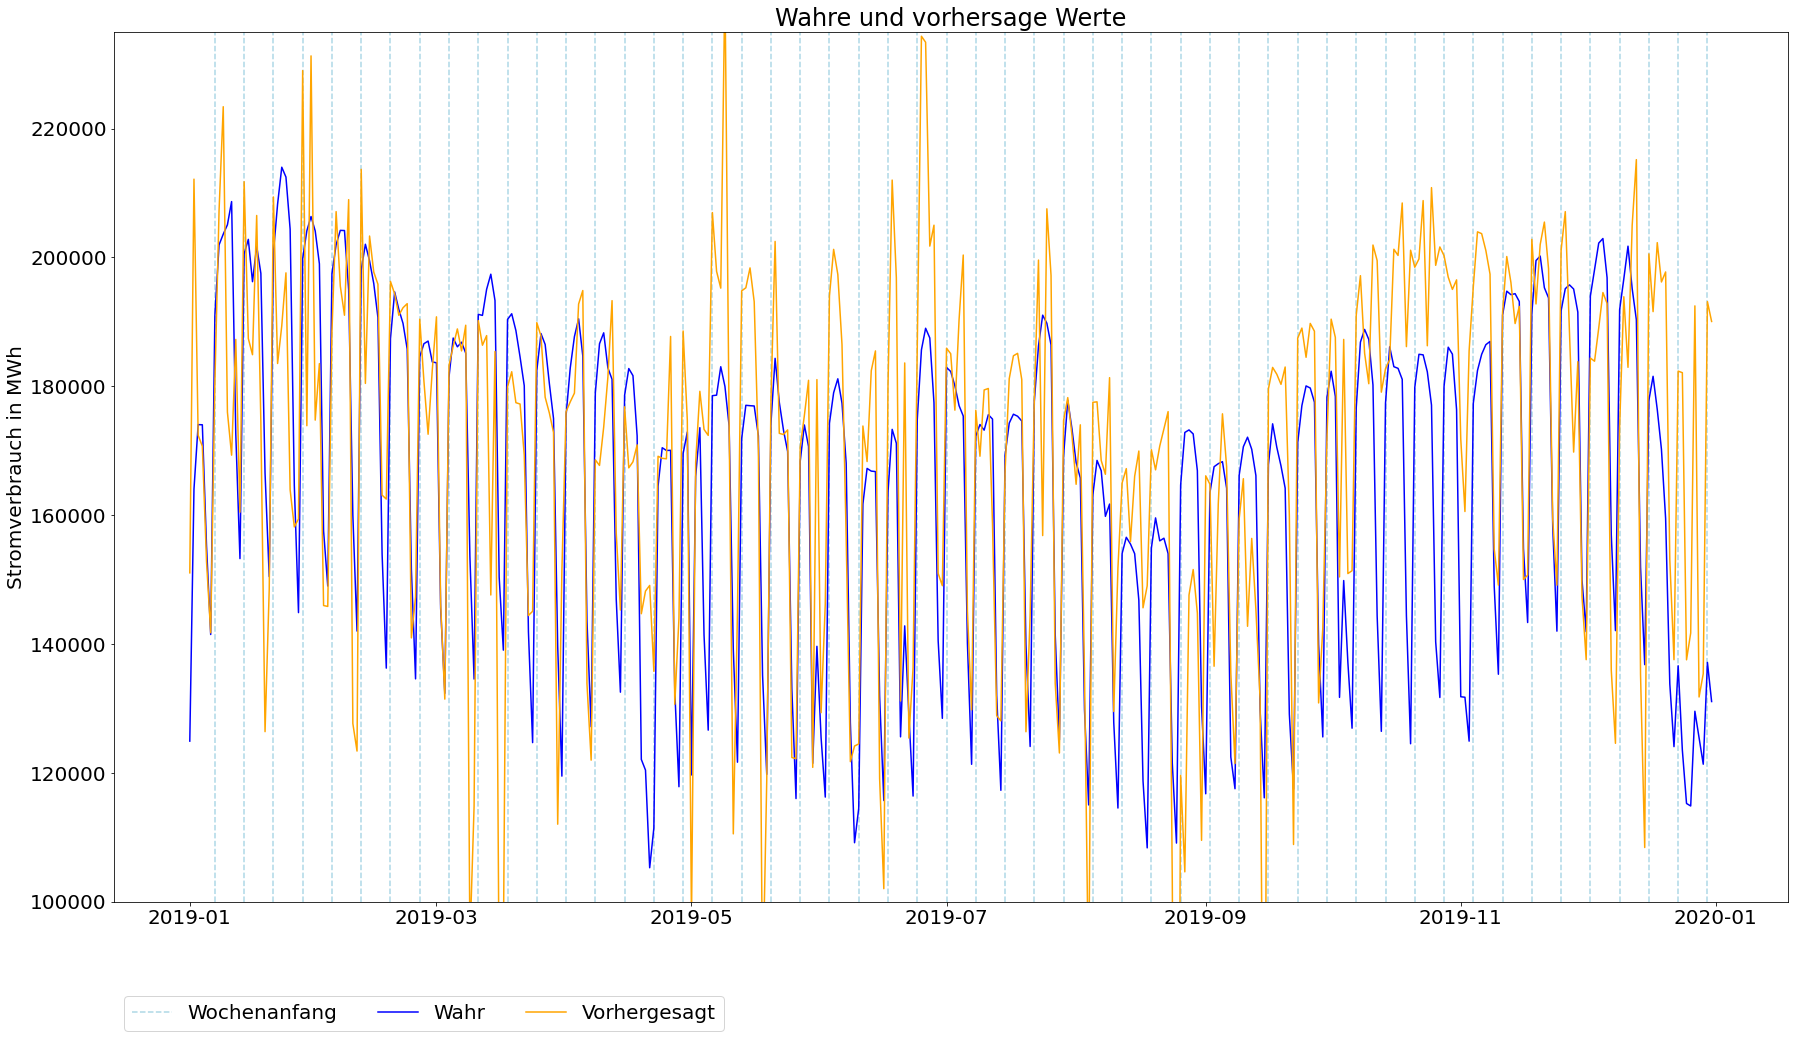

In [12]:
#Für Regression relevante Daten herausfiltern
df_regression = pd.DataFrame(data=[df["verbrauch"], df["tagesstunden"], df["arbeitstag"], df["temperatur"], df["windgeschwindigkeit"]])
df_regression = df_regression.transpose()
df_regression = df_regression["2015-01-01":"2019-12-31"]

print(df_regression)

#Aufteilen in Trainings- und Testdaten
train, test = functions.train_test_split(df_regression, 365)

#Erstellen der polynomialen Merkmale
pf = PolynomialFeatures(degree=4)
pf = pf.fit(df_regression[["tagesstunden", "arbeitstag", "temperatur", "windgeschwindigkeit"]].values.reshape(-4, 4))

#Aufteilung in X und y
y_train = train["verbrauch"]
y_test = test["verbrauch"]

X_train = pf.transform(train[["tagesstunden", "arbeitstag", "temperatur", "windgeschwindigkeit"]])
X_test = pf.transform(test[["tagesstunden", "arbeitstag", "temperatur", "windgeschwindigkeit"]])

#Regressionsmodell erstellen
model = LinearRegression().fit(X_train, y_train)

#Vorhersagen erstellen
preds = model.predict(X_test)
preds = pd.Series(data=preds, index=pd.date_range('01/01/2019', periods=365, freq='D')).rename("vorhergesagter verbrauch")

#Vorhersagen auswerten
functions.custom_metrics(y_test, preds)

# <font size="7">Fazit</font>
<font size="5">Die Windgeschwindigkeit steht in keinem Zusammenhang mit dem Stromverbrauch und wird daher bei der weiteren Modellierung nicht verwendet.</font>